[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iabh1shekbasu/LungCancerDetectionEnsemble/blob/main/Probability_Extraction_and_Analysis.ipynb
)


## Connecting Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !google-drive-ocamlfuse

In [ ]:
# !xdg-settings set default-web-browser w3m.desktop # to set default browser
# %cd /content
# !mkdir drive
# %cd drive
# !mkdir MyDrive
# %cd ..
# %cd ..
# !google-drive-ocamlfuse /content/drive/MyDrive

## Importing Libraries

This section imports necessary libraries required for the entire notebook. It includes deep learning libraries such as PyTorch, data manipulation libraries like NumPy, and visualization libraries such as matplotlib.

In [2]:
import time
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import WeightedRandomSampler

## Data Preprocessing

This section defines the transformations to be applied to the input data for training and evaluation purposes. It includes normalization, resizing, and augmentation strategies.

In [3]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
       transforms.Resize((256,256)),
        transforms.ToTensor(),
    ]),
}

## Data Directory Setup

This sets the path to the directory where the dataset is stored. It's essential for the notebook to access the training and testing data.

In [7]:
data_dir = "/content/drive/MyDrive/data"  # Set the directory for the data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in [ 'test', 'train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test', 'train', 'val']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['benign', 'malignant']


## Visualization Function

Here we define a function to visualize images in the dataset. It will help in understanding the data and debugging the data loaders.

In [8]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

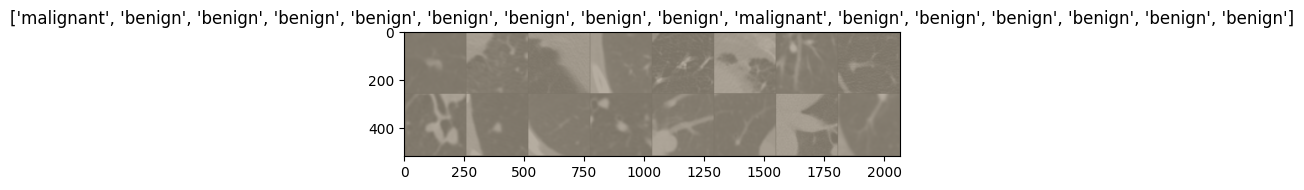

In [9]:
# Get a batch of testing data
inputs, classes = next(iter(dataloaders['test']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [10]:
def plot(val_loss,train_loss,typ):
    plt.title("{} after epoch: {}".format(typ,len(train_loss)))
    plt.xlabel("Epoch")
    plt.ylabel(typ)
    plt.plot(list(range(len(train_loss))),train_loss,color="r",label="Train "+typ)
    plt.plot(list(range(len(val_loss))),val_loss,color="b",label="Validation "+typ)
    plt.legend()
    plt.savefig(os.path.join(data_dir,typ+".png"))
    plt.close()

In [11]:
val_loss_gph=[]
train_loss_gph=[]
val_acc_gph=[]
train_acc_gph=[]

## Model Training Function

This function encapsulates the model training logic. It takes a model, criterion for loss calculation, optimizer for backpropagation, and a scheduler for learning rate adjustment as inputs and conducts the training process.

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,model_name = "kaggle"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) #was (outputs,1) for non-inception and (outputs.data,1) for inception
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
              train_loss_gph.append(epoch_loss)
              train_acc_gph.append(epoch_acc)
            if phase == 'val':
              val_loss_gph.append(epoch_loss)
              val_acc_gph.append(epoch_acc)
           # plot(val_loss_gph,train_loss_gph, "Loss")
          #  plot(val_acc_gph,train_acc_gph, "Accuracy")
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model, data_dir+"/"+model_name+".h5")
                print('==>Model Saved')
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# ResNet 152

## Model Definition and Training

This section covers the instantiation of the ResNet152 model and its subsequent training with the dataset.

In [13]:
model = models.resnet152(pretrained = True)
#num_ftrs = model.classifier[0].in_features
num_ftrs = model.fc.in_features  ##for googlenet, resnet18
#num_ftrs = model.classifier.in_features  ## for densenet169
print("Number of features: "+str(num_ftrs))
#model.classifier = nn.Linear(num_ftrs, num_classes) ## for vgg19
model.fc = nn.Linear(num_ftrs, num_classes)  ##for googlenet, resnet18
#model.classifier = nn.Linear(num_ftrs, num_classes) ## for densenet169
model = model.to(device)
criterion = nn.CrossEntropyLoss( weight = torch.tensor([1, 4.7]).to(device))
# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1)
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10, model_name = "resnet152")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 141MB/s]


Number of features: 2048
Epoch 1/10
----------
train Loss: 0.3908 Acc: 0.8460
val Loss: 0.8879 Acc: 0.8273


RuntimeError: File /content/drive/MyDrive/data/resnet152.h5 cannot be opened.

In [ ]:
# Getting Proba distribution
print("\nGetting the Probability Distribution")
trainloader=torch.utils.data.DataLoader(image_datasets['train'],batch_size=1)
testloader=torch.utils.data.DataLoader(image_datasets['test'],batch_size=1)
model=model.eval()
import csv
import numpy as np  # Importing NumPy for numerical operations

In [ ]:
f = open(data_dir+"/resnet152_train.csv",'w+',newline = '')
writer = csv.writer(f)
saving = []
correct = 0
total = 0
with torch.no_grad():
      num = 0
      temp_array = np.zeros((len(trainloader),num_classes))
      for i,data in enumerate(trainloader):
          images, labels = data
          sample_fname, _ = trainloader.dataset.samples[i]
          labels=labels.cuda()
          outputs = model(images.cuda())
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels.cuda()).sum().item()
          prob = torch.nn.functional.softmax(outputs, dim=1)
          saving.append(sample_fname.split('/')[-1])
          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])
          num+=1
print("Train Accuracy = ",100*correct/total)
for i in range(len(trainloader)):
  k = temp_array[i].tolist()
  k.append(saving[i])
  writer.writerow(k)
f.close()
f = open(data_dir+"/train_labels.csv",'w+',newline = '')
writer = csv.writer(f)
for i,data in enumerate(trainloader):
  _, labels = data
  sample_fname, _ = trainloader.dataset.samples[i]
  sample = sample_fname.split('/')[-1]
  lab = labels.tolist()[0]
  writer.writerow([sample,lab])
f.close()

In [ ]:
#Test Probabilities
f = open(data_dir+"/resnet152_test.csv",'w+',newline = '')
writer = csv.writer(f)
saving = []
correct = 0
total = 0
with torch.no_grad():
      num = 0
      temp_array = np.zeros((len(testloader),num_classes))
      for i,data in enumerate(testloader):
          images, labels = data
          sample_fname, _ = testloader.dataset.samples[i]
          labels=labels.cuda()
          outputs = model(images.cuda())
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels.cuda()).sum().item()
          prob = torch.nn.functional.softmax(outputs, dim=1)
          saving.append(sample_fname.split('/')[-1])
          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])
          num+=1
print("Test Accuracy = ",100*correct/total)
for i in range(len(testloader)):
  k = temp_array[i].tolist()
  k.append(saving[i])
  writer.writerow(k)
f.close()
f = open(data_dir+"/test_labels.csv",'w+',newline = '')
writer = csv.writer(f)
for i,data in enumerate(testloader):
  _, labels = data
  sample_fname, _ = testloader.dataset.samples[i]
  sample = sample_fname.split('/')[-1]
  lab = labels.tolist()[0]
  writer.writerow([sample,lab])
f.close()

# Inception V3

## Inception V3 Model

Following the pattern of the previous section, this part focuses on the Inception V3 model, its setup, and training.

In [ ]:
model = models.inception_v3(pretrained = True)
model.aux_logits = False
# Handle the auxilary net
num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
# Handle the primary net
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,num_classes)
print("Number of features: "+str(num_ftrs))
#model.classifier = nn.Linear(num_ftrs, num_classes) ## for vgg19
model.fc = nn.Linear(num_ftrs, num_classes)  ##for googlenet, resnet18
#model.classifier = nn.Linear(num_ftrs, num_classes) ## for densenet169
model = model.to(device)
criterion = nn.CrossEntropyLoss( weight = torch.tensor([1, 4.7]).to(device))
# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1)
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10, model_name = "inception_v3")

In [ ]:
import csv
import numpy as np
# Getting Proba distribution
print("\nGetting the Probability Distribution")
trainloader=torch.utils.data.DataLoader(image_datasets['train'],batch_size=1)
testloader=torch.utils.data.DataLoader(image_datasets['test'],batch_size=1)
model=model.eval()

In [ ]:
f = open(data_dir+"/inception_v3_train.csv",'w+',newline = '')
writer = csv.writer(f)
saving = []
correct = 0
total = 0
with torch.no_grad():
      num = 0
      temp_array = np.zeros((len(trainloader),num_classes))
      for i,data in enumerate(trainloader):
          images, labels = data
          sample_fname, _ = trainloader.dataset.samples[i]
          labels=labels.cuda()
          outputs = model(images.cuda())
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels.cuda()).sum().item()
          prob = torch.nn.functional.softmax(outputs, dim=1)
          saving.append(sample_fname.split('/')[-1])
          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])
          num+=1
print("Train Accuracy = ",100*correct/total)
for i in range(len(trainloader)):
  k = temp_array[i].tolist()
  k.append(saving[i])
  writer.writerow(k)
f.close()
f = open(data_dir+"/train_labels.csv",'w+',newline = '')
writer = csv.writer(f)
for i,data in enumerate(trainloader):
  _, labels = data
  sample_fname, _ = trainloader.dataset.samples[i]
  sample = sample_fname.split('/')[-1]
  lab = labels.tolist()[0]
  writer.writerow([sample,lab])
f.close()

In [ ]:
#Test Probabilities
f = open(data_dir+"/inception_v3_test.csv",'w+',newline = '')
writer = csv.writer(f)
saving = []
correct = 0
total = 0
with torch.no_grad():
      num = 0
      temp_array = np.zeros((len(testloader),num_classes))
      for i,data in enumerate(testloader):
          images, labels = data
          sample_fname, _ = testloader.dataset.samples[i]
          labels=labels.cuda()
          outputs = model(images.cuda())
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels.cuda()).sum().item()
          prob = torch.nn.functional.softmax(outputs, dim=1)
          saving.append(sample_fname.split('/')[-1])
          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])
          num+=1
print("Test Accuracy = ",100*correct/total)
for i in range(len(testloader)):
  k = temp_array[i].tolist()
  k.append(saving[i])
  writer.writerow(k)
f.close()
f = open(data_dir+"/test_labels.csv",'w+',newline = '')
writer = csv.writer(f)
for i,data in enumerate(testloader):
  _, labels = data
  sample_fname, _ = testloader.dataset.samples[i]
  sample = sample_fname.split('/')[-1]
  lab = labels.tolist()[0]
  writer.writerow([sample,lab])
f.close()

# Densenet 169



## Densenet 169  Model

Following the pattern of the previous section, this part focuses on the Densenet 169 model, its setup, and training.

In [ ]:
model = models.densenet169(pretrained = True)
#num_ftrs = model.classifier[0].in_features
#num_ftrs = model.fc.in_features  ##for googlenet, resnet18
num_ftrs = model.classifier.in_features  ## for densenet169
print("Number of features: "+str(num_ftrs))
#model.classifier = nn.Linear(num_ftrs, num_classes) ## for vgg19
#model.fc = nn.Linear(num_ftrs, num_classes)  ##for googlenet, resnet18
model.classifier = nn.Linear(num_ftrs, num_classes) ## for densenet169
model = model.to(device)
criterion = nn.CrossEntropyLoss( weight = torch.tensor([1, 4.7]).to(device))
# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1)
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10, model_name = "densenet169")

In [ ]:
import csv
import numpy as np

# Getting Proba distribution
print("\nGetting the Probability Distribution")
trainloader=torch.utils.data.DataLoader(image_datasets['train'],batch_size=1)
testloader=torch.utils.data.DataLoader(image_datasets['test'],batch_size=1)
model=model.eval()


In [ ]:
f = open(data_dir+"/densenet169_train.csv",'w+',newline = '')
writer = csv.writer(f)
saving = []
correct = 0
total = 0
with torch.no_grad():
      num = 0
      temp_array = np.zeros((len(trainloader),num_classes))
      for i,data in enumerate(trainloader):
          images, labels = data
          sample_fname, _ = trainloader.dataset.samples[i]
          labels=labels.cuda()
          outputs = model(images.cuda())
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels.cuda()).sum().item()
          prob = torch.nn.functional.softmax(outputs, dim=1)
          saving.append(sample_fname.split('/')[-1])
          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])
          num+=1
print("Train Accuracy = ",100*correct/total)
for i in range(len(trainloader)):
  k = temp_array[i].tolist()
  k.append(saving[i])
  writer.writerow(k)
f.close()
f = open(data_dir+"/train_labels.csv",'w+',newline = '')
writer = csv.writer(f)
for i,data in enumerate(trainloader):
  _, labels = data
  sample_fname, _ = trainloader.dataset.samples[i]
  sample = sample_fname.split('/')[-1]
  lab = labels.tolist()[0]
  writer.writerow([sample,lab])
f.close()

In [ ]:
#Test Probabilities
f = open(data_dir+"/densenet169_test.csv",'w+',newline = '')
writer = csv.writer(f)
saving = []
correct = 0
total = 0
with torch.no_grad():
      num = 0
      temp_array = np.zeros((len(testloader),num_classes))
      for i,data in enumerate(testloader):
          images, labels = data
          sample_fname, _ = testloader.dataset.samples[i]
          labels=labels.cuda()
          outputs = model(images.cuda())
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels.cuda()).sum().item()
          prob = torch.nn.functional.softmax(outputs, dim=1)
          saving.append(sample_fname.split('/')[-1])
          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])
          num+=1
print("Test Accuracy = ",100*correct/total)
for i in range(len(testloader)):
  k = temp_array[i].tolist()
  k.append(saving[i])
  writer.writerow(k)
f.close()
f = open(data_dir+"/test_labels.csv",'w+',newline = '')
writer = csv.writer(f)
for i,data in enumerate(testloader):
  _, labels = data
  sample_fname, _ = testloader.dataset.samples[i]
  sample = sample_fname.split('/')[-1]
  lab = labels.tolist()[0]
  writer.writerow([sample,lab])
f.close()

# Efficientnet B7 Model

## Efficientnet B7 Model

Following the pattern of the previous section, this part focuses on the Efficientnet B7 model, its setup, and training.

In [ ]:
model = models.efficientnet_b7(pretrained = True)
#num_ftrs = model.classifier[0].in_features
#num_ftrs = model.fc.in_features  ##for googlenet, resnet18
#num_ftrs = model.classifier.in_features  ## for densenet169
num_ftrs = model.classifier[1].in_features   ## for efficientnet_b7
print("Number of features: "+str(num_ftrs))
#model.classifier = nn.Linear(num_ftrs, num_classes) ## for vgg19
#model.fc = nn.Linear(num_ftrs, num_classes)  ##for googlenet, resnet18
model.classifier = nn.Linear(num_ftrs, num_classes) ## for densenet169, efficientnet_b7
model = model.to(device)
criterion = nn.CrossEntropyLoss( weight = torch.tensor([1, 4.7]).to(device))
# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1)
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10, model_name = "efficientnet_b7")

In [ ]:
import csv
import numpy as np
# Getting Proba distribution
print("\nGetting the Probability Distribution")
trainloader=torch.utils.data.DataLoader(image_datasets['train'],batch_size=1)
testloader=torch.utils.data.DataLoader(image_datasets['test'],batch_size=1)
model=model.eval()

In [ ]:
f = open(data_dir+"/efficientnetb7_train.csv",'w+',newline = '')
writer = csv.writer(f)
saving = []
correct = 0
total = 0
with torch.no_grad():
      num = 0
      temp_array = np.zeros((len(trainloader),num_classes))
      for i,data in enumerate(trainloader):
          images, labels = data
          sample_fname, _ = trainloader.dataset.samples[i]
          labels=labels.cuda()
          outputs = model(images.cuda())
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels.cuda()).sum().item()
          prob = torch.nn.functional.softmax(outputs, dim=1)
          saving.append(sample_fname.split('/')[-1])
          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])
          num+=1
print("Train Accuracy = ",100*correct/total)
for i in range(len(trainloader)):
  k = temp_array[i].tolist()
  k.append(saving[i])
  writer.writerow(k)
f.close()
f = open(data_dir+"/train_labels.csv",'w+',newline = '')
writer = csv.writer(f)
for i,data in enumerate(trainloader):
  _, labels = data
  sample_fname, _ = trainloader.dataset.samples[i]
  sample = sample_fname.split('/')[-1]
  lab = labels.tolist()[0]
  writer.writerow([sample,lab])
f.close()

In [ ]:
#Test Probabilities
f = open(data_dir+"/efficientnetb7_test.csv",'w+',newline = '')
writer = csv.writer(f)
saving = []
correct = 0
total = 0
with torch.no_grad():
      num = 0
      temp_array = np.zeros((len(testloader),num_classes))
      for i,data in enumerate(testloader):
          images, labels = data
          sample_fname, _ = testloader.dataset.samples[i]
          labels=labels.cuda()
          outputs = model(images.cuda())
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels.cuda()).sum().item()
          prob = torch.nn.functional.softmax(outputs, dim=1)
          saving.append(sample_fname.split('/')[-1])
          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])
          num+=1
print("Test Accuracy = ",100*correct/total)
for i in range(len(testloader)):
  k = temp_array[i].tolist()
  k.append(saving[i])
  writer.writerow(k)
f.close()
f = open(data_dir+"/test_labels.csv",'w+',newline = '')
writer = csv.writer(f)
for i,data in enumerate(testloader):
  _, labels = data
  sample_fname, _ = testloader.dataset.samples[i]
  sample = sample_fname.split('/')[-1]
  lab = labels.tolist()[0]
  writer.writerow([sample,lab])
f.close()

# Ensemble Learning Analysis

## Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
import matplotlib.pyplot as plt
import math,os,argparse
from scikitplot.estimators import plot_feature_importances
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

## Data Loading

In [ ]:
parser.add_argument('--root_train', type=str, required = True, help='Directory where train csv files are stored')
parser.add_argument('--train_labels', type=str, required = True, help='File path for train labels')
parser.add_argument('--root_test', type=str, required = True, help='Directory where test csv files are stored')
parser.add_argument('--test_labels', type=str, required = True, help='File path for test labels')
    df = pd.read_csv(file,header=None)
    df = pd.read_csv(file,header=None)

## Helper Functions

In [ ]:
def predicting(ensemble_prob):
    prediction = np.zeros((ensemble_prob.shape[0],))
    for i in range(ensemble_prob.shape[0]):
        temp = ensemble_prob[i]
        t = np.where(temp == np.max(temp))[0][0]
        prediction[i] = t
    return prediction

def getfile(filename):
    root="./"
    file = root+filename
    if '.csv' not in file:
        file+='.csv'
    df = pd.read_csv(file,header=None)
    df = np.asarray(df)[:,:-1] #Since last column has image names
    return df

def metrics(labels,predictions,classes):
    print("Classification Report:")
    print(classification_report(labels, predictions, target_names = classes,digits = 4))
    matrix = confusion_matrix(labels, predictions)
    accuracy = accuracy_score(labels,predictions)
    pre = precision_score(labels,predictions)
    rec = recall_score(labels,predictions)
    f1 = f1_score(labels,predictions)
    auc = roc_auc_score(labels,predictions)
    print("Accuracy", accuracy)
    print("Precision Score", pre)
    print("Recall Score", rec)
    print("F1 Score", f1)
    print("Roc_Auc Score", auc)
    print("Confusion matrix:")
    print(matrix)
    print("\nClasswise Accuracy :{}".format(matrix.diagonal()/matrix.sum(axis = 1)))

# Plot ROC Curve Function

In [ ]:
#ROC-AUC
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

def plot_roc(val_label,decision_val, caption='ROC Curve'):
    num_classes=np.unique(val_label).shape[0]
    classes = []
    for i in range(num_classes):
        classes.append(i)
    plt.figure()
    decision_val = label_binarize(decision_val, classes=classes)

    if num_classes!=2:
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            y_val = label_binarize(val_label, classes=classes)
            fpr[i], tpr[i], _ = roc_curve(y_val[:, i], decision_val[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(i+1, roc_auc[i]))
    else:
        fpr,tpr,_ = roc_curve(val_label,decision_val, pos_label=1)
        roc_auc = auc(fpr,tpr)*100
        plt.plot(fpr,tpr,label='ROC curve (AUC=%0.2f)'%roc_auc)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(caption)
    plt.legend(loc="lower right")
    plt.savefig(str(len(classes))+'RE_NAME.png',dpi=300)


#plot_roc(test_labels,preds_Adjusted)
plot_roc(test_labels,preds_original)

# Analysis


In [ ]:
# Function to calculate scores for each model
def get_scores(labels, *models_predictions):
    """
    Calculates precision, recall, f1-score, and AUC for each model's predictions.

    :param labels: The ground truth labels.
    :param models_predictions: Variable number of arrays with model predictions.
    :return: A list of weights for each set of model predictions.
    """
    num_models = len(models_predictions)
    # Initialize metrics array
    metrics = np.zeros((2, num_models))
    num_classes = len(np.unique(labels))

    for i, model_preds in enumerate(models_predictions):
        # Simulate a predicting function for model predictions
        preds = predicting(model_preds)

        # Calculate different metrics depending on the number of classes
        if num_classes == 2:  # Binary classification
            pre = precision_score(labels, preds)
            rec = recall_score(labels, preds)
            f1 = f1_score(labels, preds)
            auc = roc_auc_score(labels, preds)
        else:  # Multiclass classification
            pre = precision_score(labels, preds, average='macro')
            rec = recall_score(labels, preds, average='macro')
            f1 = f1_score(labels, preds, average='macro')
            auc = roc_auc_score(labels, model_preds, average='macro', multi_class='ovo')

        # Update metrics array with the calculated metrics
        metrics[:, i] = np.array([f1, auc])

    # Output the f1 and auc scores for each model
    print("F1 Score", metrics[0] * 100)
    print("ROC_AUC Score", metrics[1] * 100)

    # Calculate weights based on the metrics
    weights = get_weights(np.transpose(metrics))
    return weights

def get_weights(matrix):
    """
    Calculates weights for each model using the tanh function on the metrics.

    :param matrix: A matrix of shape (number of models, number of metrics).
    :return: A list of weights for each model.
    """
    weights = []
    for model_metrics in matrix:
        # Use tanh to compute a weighted sum of metrics for each model
        weight = np.sum(np.tanh(model_metrics))
        weights.append(weight)
    return weights

# Ensure the training root path ends with a slash
root_train = args.root_train
if root_train[-1] != '/':
    root_train += '/'

# Ensure the testing root path ends with a slash
root_test = args.root_test
if root_test[-1] != '/':
    root_test += '/'

# Define the filenames for the training predictions from different models
train1 = "densenet169_train_adam"
train2 = "efficientnetb7_train_adam"
train3 = "resnet152_train_adam"

# Retrieve the predictions from files for training data
p1_train = getfile(root_train + train1)  # Get predictions for the first model
p2_train = getfile(root_train + train2)  # Get predictions for the second model
p3_train = getfile(root_train + train3)  # Get predictions for the third model

# Load the labels for the training data
train_labels = getlabels(args.train_labels)

# Define the filenames for the testing predictions from different models
test1 = "densenet169_test_adam"
test2 = "efficientnetb7_test_adam"
test3 = "resnet152_test_adam"

# Retrieve the predictions from files for testing data
p1_test = getfile(root_test + test1)  # Get predictions for the first model
p2_test = getfile(root_test + test2)  # Get predictions for the second model
p3_test = getfile(root_test + test3)  # Get predictions for the third model

# Load the labels for the testing data
test_labels = getlabels(args.test_labels)

# Print the order of CSV files
print("Train CSV's Order", train1 + ", " + train2 + ", " + train3)
print("\n")
print("Test CSV's Order", test1 + ", " + test2 + ", " + test3)
print("\n")

# Display header for training data metrics
print("Training Data Metrics")
print("--------------------------------------------------------------------------------------")
print(train1 + " " + train2 + " " + train3)
print("--------------------------------------------------------------------------------------")

# Get weights based on training labels and predictions
weights = get_scores(train_labels, p1_train, p2_train, p3_train)
print("\n")

# Display header for testing data metrics
print("Testing Data Metrics")
print("--------------------------------------------------------------------------------------")
print(test1 + " " + test2 + " " + test3)
print("--------------------------------------------------------------------------------------")
weight = get_scores(test_labels, p1_test, p2_test, p3_test)
print("\n")

# Display original weights
print("Original Weights")
print("--------------------------------------------------------------------------------------")
print(train1, weights[0])
print(train2, weights[1])
print(train3, weights[2])
print("\n")

# Calculate ensemble probabilities using the original weights
ensemble_prob_original = weights[0] * p1_test + weights[1] * p2_test + weights[2] * p3_test

# Display ensemble probabilities with original weights
print("Ensemble Probabilities with Original Weights", ensemble_prob_original)
print("--------------------------------------------------------------------------------------")
print("\n")

# Generate predictions using the original ensemble probabilities
preds_original = predicting(ensemble_prob_original)

# Display predictions with original weights
print("Predictions with Original Weights", preds_original)
print("--------------------------------------------------------------------------------------")
print("\n")

# Normalize the weights so they sum up to 1
w0, w1, w2 = weights
w0_norm = w0 / (w0 + w1 + w2)
w1_norm = w1 / (w0 + w1 + w2)
w2_norm = w2 / (w0 + w1 + w2)

# Display normalized weights
print("Normalised Weights")
print("--------------------------------------------------------------------------------------")
print(train1, w0_norm)
print(train2, w1_norm)
print(train3, w2_norm)
print("\n")

# Calculate ensemble probabilities using the normalized weights
ensemble_prob_Normal = w0_norm * p1_test + w1_norm * p2_test + w2_norm * p3_test

# Display ensemble probabilities with normalized weights
print("Ensemble Probabilities with Normal Weights", ensemble_prob_Normal)
print("--------------------------------------------------------------------------------------")
print("\n")

# Generate predictions using the normalized ensemble probabilities
preds_Normal = predicting(ensemble_prob_Normal)

# Display predictions with normalized weights
print("Predictions with Normal Weights", preds_Normal)
print("--------------------------------------------------------------------------------------")
print("\n")

# Manually adjusted weights based on empirical findings
w0_adj = 0.3585864 # Best Weights for some criterion
w1_adj = 0.3441670 # Best Weights for some criterion
w2_adj = 0.2972466 # Best Weights for some criterion

# Display adjusted weights
print("Adjusted Weights")
print("--------------------------------------------------------------------------------------")
print(train1, w0_adj)
print(train2, w1_adj)
print(train3, w2_adj)
print("\n")

# Calculate ensemble probabilities using the adjusted weights
ensemble_prob_Adjusted = w0_adj * p1_test + w1_adj * p2_test + w2_adj * p3_test

# Display ensemble probabilities after updating weights
print("Ensemble Probabilities After Updating Weights", ensemble_prob_Adjusted)
print("--------------------------------------------------------------------------------------")
print("\n")

# Generate predictions using the adjusted ensemble probabilities
preds_Adjusted = predicting(ensemble_prob_Adjusted)

# Display predictions after updating weights
print("Predictions After Updating Weights", preds_Adjusted)
print("--------------------------------------------------------------------------------------")
print("\n")

# Calculate the number of correct predictions with original weights and print accuracy
correct_original = np.where(preds_original == test_labels)[0].shape[0]
total = test_labels.shape[0]
print("\n")
print("Accuracy (Original) = ", (correct_original / total) * 100)
print("\n")

# Print classification metrics for the predictions made with original weights
classes = ['Benign', 'Malignant']
metrics(test_labels, preds_original, classes)

# Calculate the number of correct predictions with normalized weights and print accuracy
correct_Normal = np.where(preds_Normal == test_labels)[0].shape[0]
print("\n")
print("Accuracy (Normal) = ", (correct_Normal / total) * 100)
print("\n")

# Print classification metrics for the predictions made with normalized weights
metrics(test_labels, preds_Normal, classes)